<div class="output_png output_subarea output_execute_result">
<center>
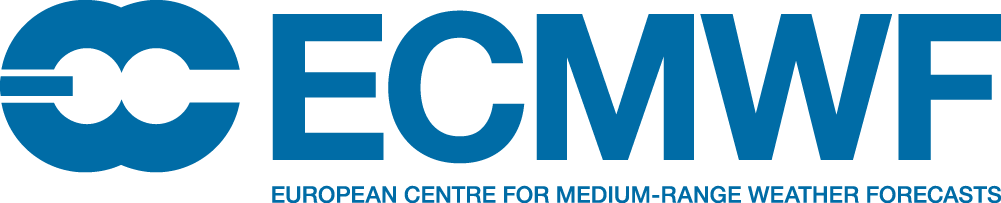</center>
</div>

# 	Temperature and geopotential at various pressure levels

This notebook will provide you guidance how to explore and plot ECMWF open dataset to produce the map from the ECMWF open charts web product.  
The original product can be found on this link: https://apps.ecmwf.int/webapps/opencharts/products/medium-t-z


<div class="output_png output_subarea output_execute_result">
<center>
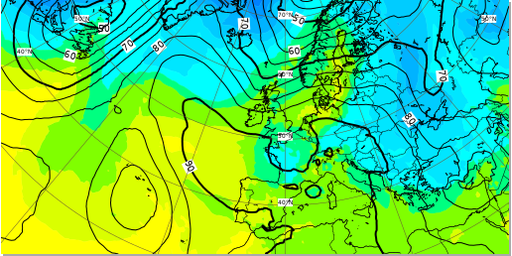</center>
</div>

The full list of available Open data products can be found [here](https://www.ecmwf.int/en/forecasts/datasets/open-data), and more information can be found in the [User documentation](https://confluence.ecmwf.int/display/UDOC/ECMWF+Open+Data+-+Real+Time).  

Access to ECMWF Open data is governed by the Creative Commons CC-BY-4.0 licence and associated [Terms of Use](https://apps.ecmwf.int/datasets/licences/general/).  

<sub> In applying this licence, ECMWF does not waive the privileges and immunities granted to it by virtue of its status as an intergovernmental organisation nor does it submit to any jurisdiction </sub>

To find out how to obtain the access to the full forecast dataset at higher resolution please visit our [Access page](https://www.ecmwf.int/en/forecasts/accessing-forecasts).

## Retrieve Data
This product takes in input 3 parameters :

* [Geopotential height](https://apps.ecmwf.int/codes/grib/param-db/?id=156)
* [Temperature](https://apps.ecmwf.int/codes/grib/param-db/?id=130)

In this example, we will use: 
- **ecmwf.opendata** Client to download the data
- **ecmwf.data** library to read and process the data (calculate the speed and probabilities)
- **ecmwf.geomaps** to plot the result

First we need to install them in the current Jupyter kernel:  
<div class="alert alert-block alert-info">
<b>Note:</b> If you are running the notebook on MyBinder or already have the libraries installed, go directly to importing the libraries.
</div>
<div class="alert alert-block alert-info">
<b>Note:</b> If you don't have these libraries installed, click on three dots below, uncomment the code and run the next cell.
</div>

In [1]:
#import sys
#!{sys.executable} -m pip install ecmwf-data ecmwf-opendata git+https://github.com/ecmwf/ecmwf-geomaps.git

In [2]:
import ecmwf.data as ecdata
from ecmwf.geomaps import GeoMap
from ecmwf.opendata import Client

In [3]:
client = Client("ecmwf", beta=True)

In [4]:
parameters = ['t', 'gh']
filename = 'medium-t-z.grib'
filename

'medium-t-z.grib'

In [5]:
client.retrieve(
    date=-2,
    time=0,
    step=12,
    stream="oper",
    type="fc",
    levtype="pl",
    levelist=[1000,925,850,700,500,300,250,200,50],
    param=parameters,
    target=filename
)

{'date': '-2', 'time': '0', 'step': '12', 'stream': 'oper', 'type': 'fc', 'resol': '0p4-beta', '_url': 'https://ai4edataeuwest.blob.core.windows.net/ecmwf', 'extension': 'grib2'}
{'levtype': ['pl'], 'levelist': ['1000', '925', '850', '700', '500', '300', '250', '200', '50'], 'param': ['t', 'gh'], 'step': ['12'], 'type': ['fc']}


## Reading and processing the data
Now we can use **ecmwf.data** to read the file.

In [6]:
data = ecdata.read(filename)

The **describe()** function will give us the overview of the dataset.  

In [7]:
data.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,"50,200,...",20220116,0,12,None,156,od,oper,fc,0001
t,isobaricInhPa,"50,200,...",20220116,0,12,None,130,od,oper,fc,0001


And an overview of one parameter, where we can see more information, such as units or type of level.

In [8]:
data.describe('t')

shortName,t
name,Temperature
paramId,130
units,K
typeOfLevel,isobaricInhPa
level,"50,200,250,300,500,700,850,925,1000"
date,20220116
time,0
step,12
number,None
class,od


We can use **ls()** function to list all the fields in the file we downloaded.

In [9]:
data.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
Message,,,,,,,,,,
0,ecmf,gh,isobaricInhPa,200,20220116,0,12,fc,None,regular_ll
1,ecmf,gh,isobaricInhPa,850,20220116,0,12,fc,None,regular_ll
2,ecmf,gh,isobaricInhPa,1000,20220116,0,12,fc,None,regular_ll
3,ecmf,t,isobaricInhPa,1000,20220116,0,12,fc,None,regular_ll
4,ecmf,gh,isobaricInhPa,300,20220116,0,12,fc,None,regular_ll
5,ecmf,t,isobaricInhPa,250,20220116,0,12,fc,None,regular_ll
6,ecmf,t,isobaricInhPa,50,20220116,0,12,fc,None,regular_ll
7,ecmf,t,isobaricInhPa,300,20220116,0,12,fc,None,regular_ll
8,ecmf,t,isobaricInhPa,850,20220116,0,12,fc,None,regular_ll


The grib file contains all the parameters and levels, and we will use the **select()** function to filter what we need.

In [10]:
t850 = data.select(shortName= 't',level=850)
t850.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
t,isobaricInhPa,850,20220116,0,12,None,130,od,oper,fc,0001


In [11]:
gh850 = data.select(shortName= 'gh',level=850)
gh850.describe()

parameter,typeOfLevel,level,date,time,step,number,paramId,class,stream,type,experimentVersionNumber
gh,isobaricInhPa,850,20220116,0,12,None,156,od,oper,fc,0001


Geopotential height has units gpm (geopotential meters), but on the ECMWF Open charts it is plotted in geopotential decameters. To reproduce the plot we need to divide by 10.

In [12]:
gh850 /= 10

We also want to convert the temperature from Kelvin to Celsius

In [13]:
t850 -= 273.15

## Plotting the data
And finally, we can plot the data on the map. 

Magics-warning: description is not a known keyword


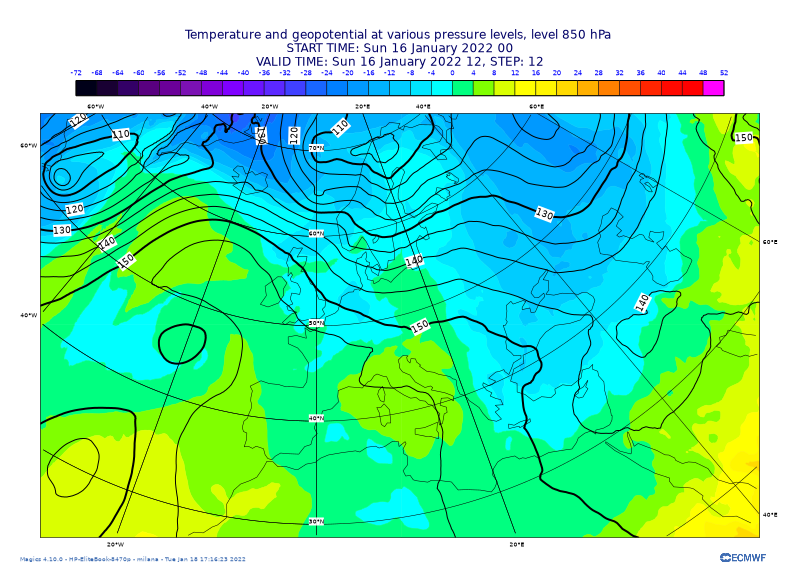

In [14]:
fig = GeoMap(area_name='europe', preset='background-foreground')

fig.contour_lines(t850, preset="sh_all_fM64t52i4")
fig.contour_lines(gh850, preset="ct_blk_i5_t2")

fig.title(["Temperature and geopotential at various pressure levels, level <grib_info key='level' where='shortName=t' /> hPa ", 
           "START TIME: <grib_info key='base-date' format='%a %d %B %Y %H' where='shortName=t'/> ",
           "VALID TIME: <grib_info key='valid-date' format='%a %d %B %Y %H' where='shortName=t'/>, STEP: <grib_info key='step' where='shortName=t' />"])
fig.legend()

fig.show()